# Risk prediction using regression

Train a regression model on the first half of the data, use it to predict risk of infection on the second half.

https://academic.oup.com/aje/article/162/10/1024/65086

https://onlinelibrary.wiley.com/doi/abs/10.1002/ajp.22542

https://arxiv.org/abs/2308.03037

NOT FINISHED!

In [1]:
import os
from os import path
import random

from datetime import datetime
import pytz

import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import networkx as nx

from utils.parsing import get_contact_list, get_infection_list, get_node_state

In [2]:
data_folder = "./data"
output_folder = "./output"
if not path.exists(output_folder):
    os.makedirs(output_folder)

# Set a random seed for reproducibility
random_seed = 32
random.seed(random_seed)

In [3]:
with open(path.join(data_folder, 'network-largest_conn_comp.pickle'), 'rb') as f:
    G = pickle.load(f)

with open(path.join(data_folder, 'daily-contact-matrices.npy'), 'rb') as f:    
    tensor = np.load(f, allow_pickle = True)

with open(path.join(data_folder, 'daily-transmissions.npy'), 'rb') as f:    
    inf = pickle.load(f)

with open(path.join(data_folder, 'daily-node-states.pickle'), 'rb') as f:
    states = pickle.load(f)

## Feature selection

In [4]:
past_window = 3
future_window = 2

feature = 'degree'
# feature = 'degree_centrality'
# feature = 'closeness_centrality'
# feature = 'betweenness_centrality'
# feature = 'eigenvector_centrality'
# feature = 'pagerank'

## Training

In [5]:
total_days = len(tensor)
train_days = round(total_days/2)

nodes0 = list(G.nodes()) # We only look at the nodes we already selected before (which have enough interactions over the entire period of the sim)

train_graphs = []
for day in range(0, train_days):
    g = nx.from_numpy_array(tensor[day])
    g = nx.relabel_nodes(g, dict(zip(g.nodes(), nodes0)), copy=True)
    train_graphs.append(g)

    degree = {node: g.degree(node) for node in g.nodes()}
    degree_centrality = nx.degree_centrality(g)
    closeness_centrality = nx.closeness_centrality(g)
    betweenness_centrality = nx.betweenness_centrality(g)
    eigenvector_centrality = nx.eigenvector_centrality(g)
    pagerank = nx.pagerank(g)

    nx.set_node_attributes(g, degree, 'degree')
    nx.set_node_attributes(g, degree_centrality, 'degree_centrality')
    nx.set_node_attributes(g, closeness_centrality, 'closeness_centrality')
    nx.set_node_attributes(g, betweenness_centrality, 'betweenness_centrality')
    nx.set_node_attributes(g, eigenvector_centrality, 'eigenvector_centrality')
    nx.set_node_attributes(g, pagerank, 'pagerank')

In [6]:
# States:
# 0 = Susceptible
# 1 = Infected (index case)
# 2 = Infected (from someone else)
# 3 =  Dead 
# 4 = Recovered 
# 5 = Vaccinated 

x_train = []
y_train = []
for day in range(0, train_days):
    std = states[day]
    print(day)
    for node in nodes0:
        idx = nodes0.index(node)
        feat = []
        for dpast in range(max(0, day - past_window), day + 1):
            gd = train_graphs[dpast]            
            feat.append(nx.get_node_attributes(gd, feature)[node])
        mean_feat = np.mean(feat)
        if std[idx] == 0:
            inf_status = 0
            for dfutch in range(day + 1, min(total_days - 1, day + future_window)):
                stf = states[dfutch]
                if stf[idx] == 2:
                    inf_status = 1
                    break
            # print(mean_feat, inf_status)
            x_train.append(mean_feat)
            y_train.append(inf_status)

0
1
2
3
4
5
6
7


In [7]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [8]:
x = np.array(x_train).reshape(-1, 1)
y = np.array(y_train)

model.fit(x, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [9]:
model.predict(x)

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
model.score(x, y)

0.8735229759299781

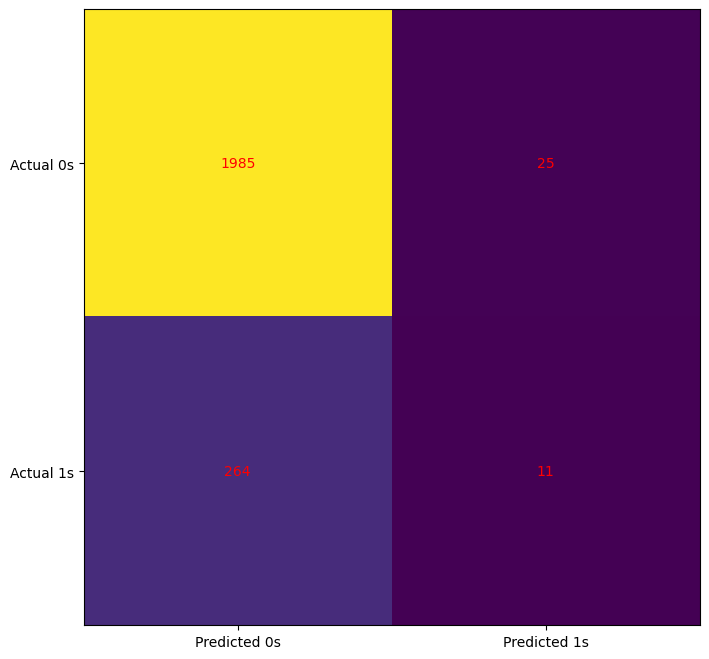

In [11]:
cm = confusion_matrix(y, model.predict(x))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [12]:
print(classification_report(y, model.predict(x)))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2010
           1       0.31      0.04      0.07       275

    accuracy                           0.87      2285
   macro avg       0.59      0.51      0.50      2285
weighted avg       0.81      0.87      0.83      2285



## Testing

In [13]:
test_graphs = []
for day in range(train_days, total_days - 1):
    print(day)
    g = nx.from_numpy_array(tensor[day])
    g = nx.relabel_nodes(g, dict(zip(g.nodes(), nodes0)), copy=True)
    test_graphs.append(g)

    degree = {node: g.degree(node) for node in g.nodes()}
    degree_centrality = nx.degree_centrality(g)
    closeness_centrality = nx.closeness_centrality(g)
    betweenness_centrality = nx.betweenness_centrality(g)
    # eigenvector_centrality = nx.eigenvector_centrality(g)
    pagerank = nx.pagerank(g)

    nx.set_node_attributes(g, degree, 'degree')
    nx.set_node_attributes(g, degree_centrality, 'degree_centrality')
    nx.set_node_attributes(g, closeness_centrality, 'closeness_centrality')
    nx.set_node_attributes(g, betweenness_centrality, 'betweenness_centrality')
    nx.set_node_attributes(g, eigenvector_centrality, 'eigenvector_centrality')
    nx.set_node_attributes(g, pagerank, 'pagerank')

8
9
10
11
12
13


In [14]:
x_test = []
y_test = []
for day in range(train_days, total_days - 1):
    print(day)
    std = states[day]  
    for node in nodes0:
        idx = nodes0.index(node)
        feat = []
        for dpast in range(max(train_days, day - past_window), day + 1):
            gd = test_graphs[dpast - train_days]
            feat.append(nx.get_node_attributes(gd, feature)[node])
        mean_feat = np.mean(feat)
        if std[idx] == 0:
            inf_status = 0
            for dfutch in range(day + 1, min(total_days - 1, day + future_window)):
                stf = states[dfutch]
                if stf[idx] == 2:
                    inf_status = 1
                    break
            # print(mean_degree, inf_status)
            x_test.append(mean_feat)
            y_test.append(inf_status)

8
9
10
11
12
13


In [15]:
x = np.array(x_test).reshape(-1, 1)
y = np.array(y_test)

In [16]:
model.predict(x)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
model.score(x, y)

0.9782833505687694

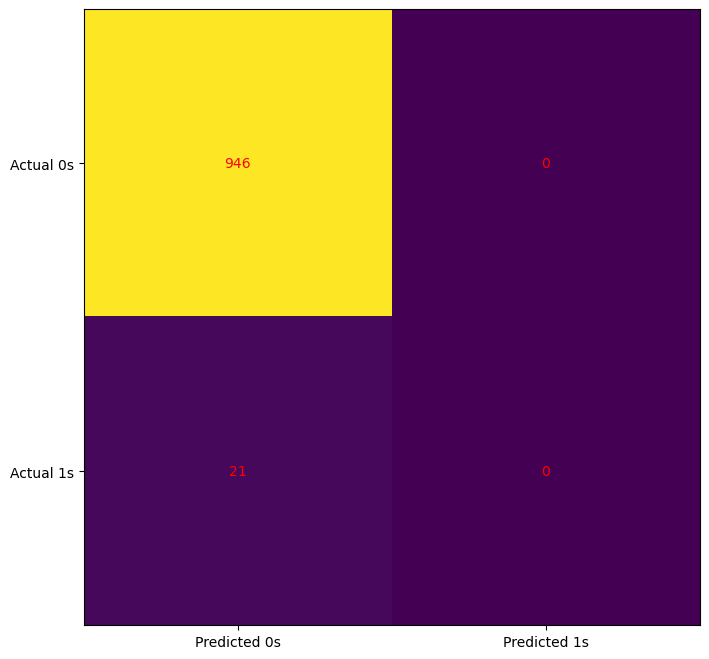

In [18]:
cm = confusion_matrix(y, model.predict(x))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [19]:
print(classification_report(y, model.predict(x)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       946
           1       0.00      0.00      0.00        21

    accuracy                           0.98       967
   macro avg       0.49      0.50      0.49       967
weighted avg       0.96      0.98      0.97       967



/Users/andres/miniconda3/envs/oo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andres/miniconda3/envs/oo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andres/miniconda3/envs/oo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i